# Regression model for predicting SaO2 from SpO2 + additional patient data

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy.special import logit, expit

## Data import and pre-processing

In [167]:
df = pd.read_csv('../data/mimic_pulseOx_data.csv')
pd.options.display.max_columns = df.shape[1]

# Remove SaO2 and SpO2 values that are above 100
df = df[(df['SaO2'] <= 100) & (df['SpO2'] <= 100)]
#print(df.shape)

# Remove  erroneous SaO2 and SpO2 values that are too low
# using a cutoff of 70
df = df[(df['SaO2'] >= 70) & (df['SpO2'] >= 70)]

In [168]:
## For people with race_group = 'Other' but race = 'UNKNOWN', change race_group to 'Unknown'
## (Because Unknown race is different from 'Other' race)
## Do the same for race = 'PATIENT DECLINED TO ANSWER' and 'UNABLE TO OBTAIN'
### First add 'Unknown' as a category
df['race_group'] = df['race_group'].copy().astype('category')
df['race_group'] = df.race_group.cat.add_categories(new_categories = 'Unknown')

### Then do the replacements
df.race_group.loc[df.race == 'UNKNOWN'] = 'Unknown'
df.race_group.loc[df.race == 'PATIENT DECLINED TO ANSWER'] = 'Unknown'
df.race_group.loc[df.race == 'UNABLE TO OBTAIN'] = 'Unknown'

## Also make sure those coded as multiracial get the 'Other' label
df.race_group.loc[df.race == 'MULTIPLE RACE/ETHNICITY'] = 'Other'

In [169]:
## Convert SaO2 and SpO2 percentages to logit-transformed proportions
## epsilon is the small number we add to all values to avoid divide-by-zero and log(0) problems
epsilon = .001

df = df.assign(SaO2_prop = df['SaO2']/100)
df = df.assign(SaO2_logit = np.log(
    (df.SaO2_prop + epsilon)/(1 + epsilon - df.SaO2_prop)))
    
df = df.assign(SpO2_prop = df['SpO2']/100)
df = df.assign(SpO2_logit = np.log(
    (df.SpO2_prop + epsilon)/(1 + epsilon - df.SpO2_prop)))

### Features

In [170]:
# Continuous features:
cont_features = ['SpO2','SpO2_logit','anchor_age','weight','height','FiO2','heart_rate','mbp','resp_rate','temperature']
normalizable_cont_features = ['anchor_age','weight','height','FiO2','heart_rate','mbp','resp_rate','temperature']
# Categorical features:
cat_features = ['gender','race_group','heart_rhythm']
# Using xgboost's category encoding requires the categorical columns having type 'category'
df[cat_features] = df[cat_features].copy().astype('category')

# Normalizing all continuous variables by maximum value. 
# Comment-out this for loop if you don't want to normalize. 
for string in normalizable_cont_features:
    df[string] = df[string].astype(float)/(df[string].astype(float).max())

### Label

In [171]:
# We are trying to predict SaO2 via regression.
# Keep both SaO2 and SaO2_logit for access to both
predict = ['SaO2','SaO2_logit']

### Use IterativeImputer for continuous variable NaN interpolation

In [172]:
# Source: https://towardsdatascience.com/a-better-way-to-handle-missing-values-in-your-dataset-using-iterativeimputer-9e6e84857d98#f326
# This works by approximating the underlying distribution of the variables and sampling that,
# rather than naively filling NaN with the mean or median value in that column. 
imputed_df = df.copy()
imp = IterativeImputer(max_iter = 20)
imputed_df[cont_features] = imp.fit_transform(imputed_df[cont_features])

## Train-test split, stratified on hidden hypoxemia

In [173]:
# Train test split stratified on hidden hypoxemia, so the small number of patients
# with hidden hypoxia are evenly distributed between train and test sets

## Make the split
df_train,df_test = train_test_split(imputed_df.copy(),
                                            shuffle=True,
                                            #random_state=42,
                                            stratify=df['hidden_hypoxemia'])

## Define X_train and y_train
X_train = df_train[cont_features + cat_features]
y_train = df_train[predict]

## Define X_test and y_test
X_test = df_test[cont_features + cat_features]
y_test = df_test[predict]

## Undersampling of patients with high SaO2 values (these are overrepresented in dataset - see EDA notebook)

In [174]:
# Define bins, display counts
bins = [0,80,85,90,95,101]
binID = pd.cut(y_train.SaO2, bins, right=False, retbins=False)
binID.value_counts()

[95, 101)    47988
[90, 95)     10455
[85, 90)      1747
[80, 85)       442
[0, 80)        239
Name: SaO2, dtype: int64

In [175]:
# Create y_train df with bin labels for each value
combine_y = {'SaO2': y_train.SaO2, 'SaO2_logit': y_train.SaO2_logit, 'binID': binID}
y_train_binned = pd.DataFrame(combine_y)
y_train_binned.head()

,SaO2,SaO2_logit,binID
14512,98.0,3.844050,"[95, 101)"
34715,95.0,2.925688,"[95, 101)"
21359,96.0,3.154402,"[95, 101)"
28321,91.0,2.303683,"[90, 95)"
79866,98.0,3.844050,"[95, 101)"


### Resampling from binned data and fitting model

This method samples (without replacement) the same number of patients from each bin.

(bins are: <80, \[80-85), [85-90), [90-95), and [95-100] ).

In our undersampling procedure, the number of samples taken from each bin equals the total number of samples in the bin with the fewest samples (0-80).
This means our undersampling method *always* includes all patients with SaO2 below 81, then randomly undersamples patients with SaO2 above 80.

Ensemble procedure: 
- Take 100 undersampled subset of binned data as described above.
- Fit XGBRegressor to each data subset.
- For ensemble predictions, calculate predictions of all 100 regression models, then average them.

In [176]:
y_train_binned.binID.value_counts()

[95, 101)    47988
[90, 95)     10455
[85, 90)      1747
[80, 85)       442
[0, 80)        239
Name: binID, dtype: int64

In [177]:
n_resamples = min(y_train_binned.binID.value_counts())
n_resamples

239

In [178]:
# Because we will use logit-transformed SpO2 values (already present in our dataframes),
# we must drop raw SpO2 values from feature matrix before proceeding.
X_train3 = X_train.copy().drop(columns = 'SpO2')

## Undersampling, fitting, test on X_test, y_test

In [179]:
# Uses X_train3 dataset, with logit-transformed SpO2
# Uses logit-tranformed SaO2 values for y_train ('SaO2_logit') 

reg_set = []

# These hyperparameter values were selected following a grid search (separate notebook)
num_estimators = 40
depth = 2
lrate = .2

## Make undersampling, model fitting, and y_pred into a loop
n_undersampled_datasets = 100
n_resamples = min(y_train_binned.binID.value_counts())

for i in range(n_undersampled_datasets):
    y_train_sub = y_train_binned.groupby('binID').sample(n=n_resamples, replace=False)
    X_train_sub = X_train3.loc[y_train_sub.index]

    if i % 10 == 0:
        print("This is loop #",i)

     ## Create XGBoost Regressor with early stopping.
    xgb_reg = xgboost.XGBRegressor(tree_method = 'approx', 
                                   enable_categorical = True,
                                   learning_rate=lrate,
                                   max_depth=depth,
                                   n_estimators= num_estimators)
    
    ## Fit model to undersampled data subset
    xgb_reg.fit(X_train_sub, y_train_sub.SaO2_logit)
    
    ## Save model to list
    reg_set.append(xgb_reg)
    
    ## Delete XGBRegressor before fitting the next one
    del xgb_reg

print("Done!", n_undersampled_datasets,
      "undersampled data subsets have been created and model trained on each.")

This is loop # 0
This is loop # 10
This is loop # 20
This is loop # 30
This is loop # 40
This is loop # 50
This is loop # 60
This is loop # 70
This is loop # 80
This is loop # 90
Done! 100 undersampled data subsets have been created and model trained on each.


### Enembled SaO2 predictions for y_test from X_test

In [180]:
predictions = []
for reg in reg_set:
    y_pred = pd.Series(reg.predict(X_test.copy().drop(columns = 'SpO2')), index=X_test.index)
    predictions.append(y_pred)
averaged_predictions = pd.DataFrame(predictions).mean(axis=0)

### Calculate various RMSE comparisons

In [181]:
# In logit units

# Calculate RMSE. Remember to back-transform predictions from logit scale to original scale,
# using expit() function from scipy.special

rmse = np.sqrt(mean_squared_error(y_test.SaO2_logit, averaged_predictions))
print(round(rmse,3), "is the RMSE for the fit to test data, in logit units")

1.046 is the RMSE for the fit to test data, in logit units


In [182]:
# In logit units
# Calculate RMSE between SaO2 and *SpO2*, to get baseline RMSE

rmse = np.sqrt(mean_squared_error(y_test.SaO2_logit, X_test.SpO2_logit))
print(round(rmse,3), "is the baseline RMSE between SpO2 and SaO2, in logit units")

1.875 is the baseline RMSE between SpO2 and SaO2, in logit units


In [183]:
# In orig units

# Calculate RMSE. Remember to back-transform predictions from logit scale to original scale,
# using expit() function from scipy.special

rmse = np.sqrt(mean_squared_error(y_test.SaO2, expit(averaged_predictions)*100))
print(round(rmse,3), "is the RMSE for the fit to test data, in orig units")

4.7 is the RMSE for the fit to test data, in orig units


In [184]:
# In orig units
# Calculate RMSE between SaO2 and *SpO2*, to get baseline RMSE

rmse = np.sqrt(mean_squared_error(y_test.SaO2, X_test.SpO2))
print(round(rmse,3), "is the baseline RMSE between SpO2 and SaO2, in orig units")

3.37 is the baseline RMSE between SpO2 and SaO2, in orig units


I realize now that the comparisons above are not appropriate, because we know our model predicts SaO2 for high, healthy values less well than SpO2 alone. This 'cost' comes with the benefit of predicting SaO2 **better** for patients with low (hypoxemia) SaO2 values.
See below for a more appropriate RMSE comparison.

#### RMSE for subset of patients with hypoxemia (SaO2 below 88) -- *this* is the relevant comparison

In [185]:
y_test2 = y_test[y_test.SaO2 < 88]
X_test2 = X_test.loc[y_test2.index]

In [186]:
# In logit units

# Calculate RMSE. Remember to back-transform predictions from logit scale to original scale,
# using expit() function from scipy.special

rmse = np.sqrt(mean_squared_error(y_test2.SaO2_logit, averaged_predictions.loc[y_test2.index]))
print(round(rmse,3), "is the RMSE for the fit to test data, in logit units")

0.586 is the RMSE for the fit to test data, in logit units


In [187]:
# In logit units
# Calculate RMSE between SaO2 and *SpO2*, to get baseline RMSE

rmse = np.sqrt(mean_squared_error(y_test2.SaO2_logit, X_test2.SpO2_logit))
print(round(rmse,3), "is the baseline RMSE between SpO2 and SaO2, in logit units")

1.667 is the baseline RMSE between SpO2 and SaO2, in logit units


In [188]:
# In orig units

# Calculate RMSE between actual and predicted, with back-transform
rmse = np.sqrt(mean_squared_error(y_test2.SaO2, expit(averaged_predictions.loc[y_test2.index])*100))
print(round(rmse,3), "is the RMSE for the fit to test data, in orig units")

7.012 is the RMSE for the fit to test data, in orig units


In [189]:
# In orig units
# Calculate RMSE between SaO2 and *SpO2*, to get baseline RMSE

rmse = np.sqrt(mean_squared_error(y_test2.SaO2, X_test2.SpO2))
print(round(rmse,3), "is the baseline RMSE between SpO2 and SaO2, in orig units")

10.375 is the baseline RMSE between SpO2 and SaO2, in orig units


In [190]:
# In orig units for ENTIRE dataset

df2 = df[df.SaO2 < 88]

# Calculate RMSE between SaO2 and *SpO2*, to get baseline RMSE

rmse = np.sqrt(mean_squared_error(df2.SaO2, df2.SpO2))
print(round(rmse,3), "is the baseline RMSE for ENTIRE dataset, between SpO2 and SaO2, in orig units")

10.173 is the baseline RMSE for ENTIRE dataset, between SpO2 and SaO2, in orig units


## Get feature importances

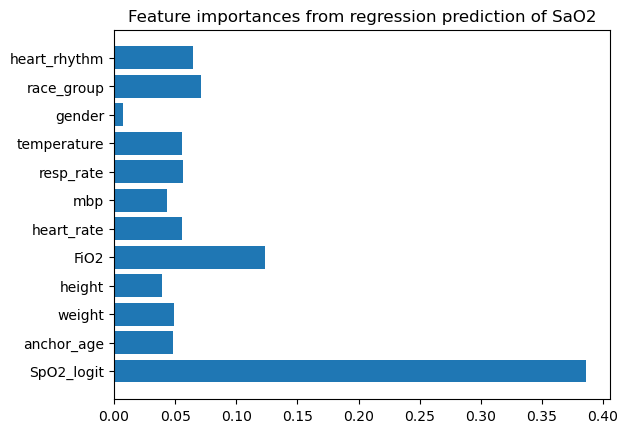

In [191]:
feature_names = reg_set[0].get_booster().feature_names
ensemble_importances = []
for reg in reg_set:
    ensemble_importances.append(reg.feature_importances_)
averaged_importances = list(pd.DataFrame(ensemble_importances).mean(axis = 0))

plt.barh(feature_names, averaged_importances)
plt.title('Feature importances from regression prediction of SaO2');


plt.savefig('../plots/Regression_feature_importances.png', dpi=600, format='png', bbox_inches='tight')

## Plot predicted SaO2 against actual SaO2

In [192]:
d = {'SaO2': y_test.SaO2, 
     'SaO2_pred': expit(averaged_predictions)*100, 
     'race_group': X_test['race_group'],
     'SpO2' : X_test['SpO2']
    }

output = pd.DataFrame(data=d)

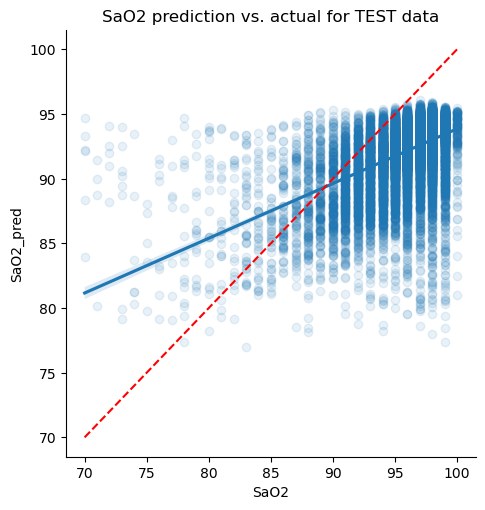

In [193]:
sns.lmplot(data = output,
                x = 'SaO2',
                y = 'SaO2_pred',
                #hue = 'race_group',
                scatter_kws = {'alpha': 0.1}
               )

x = np.linspace(70,100,100)
y = x

plt.title("SaO2 prediction vs. actual for TEST data")

plt.plot(x,y, 'r--');

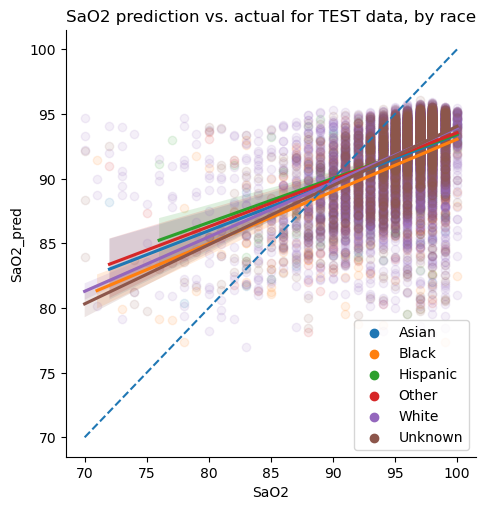

In [194]:
sns.lmplot(data = output,
                x = 'SaO2',
                y = 'SaO2_pred',
                hue = 'race_group',
                scatter_kws = {'alpha': 0.1},
                legend= False)

x = np.linspace(70,100,100)
y = x

leg = plt.legend(loc = 'lower right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.title("SaO2 prediction vs. actual for TEST data, by race")

plt.plot(x,y, linestyle = '--');

### ☝️ Nice to see that lines are very close to each other, for all race groups except 'Other'

## Residuals plot

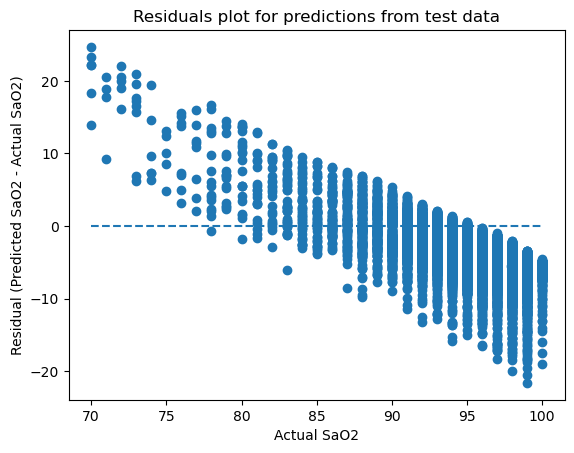

In [195]:
plt.scatter(x=output.SaO2, y=output.SaO2_pred - output.SaO2)
plt.plot(np.linspace(70,100,100), [0]*100, linestyle = '--')
plt.title("Residuals plot for predictions from test data")
plt.xlabel("Actual SaO2")
plt.ylabel("Residual (Predicted SaO2 - Actual SaO2)");

**We wanted to add a correction to the model that accounts for the systematic error shown above**. We tried several approaches but weren't able to find a solution in time.

# Illustrations for presentation

In [196]:
df = pd.read_csv('../data/mimic_pulseOx_data.csv')
pd.options.display.max_columns = df.shape[1]

# Remove SaO2 and SpO2 values that are above 100
df = df[(df['SaO2'] <= 100) & (df['SpO2'] <= 100)]
#print(df.shape)

# Remove  erroneous SaO2 and SpO2 values that are too low
# using a cutoff of 70
df = df[(df['SaO2'] >= 70) & (df['SpO2'] >= 70)]

In [197]:
d = {'SaO2': y_test.SaO2, 
     'SaO2_pred': expit(averaged_predictions)*100, 
     'race_group': X_test['race_group'],
     'SpO2' : df['SpO2'][X_test.index]
     }

output = pd.DataFrame(data=d)
output = output[output.race_group != "Other"]
output = output[output.race_group != "Unknown"]

output.head()

,SaO2,SaO2_pred,race_group,SpO2
22251,95.0,89.198242,White,99
49496,99.0,94.080986,White,100
72214,97.0,92.052361,Asian,98
76394,97.0,89.764145,White,98
70331,97.0,92.587357,White,96


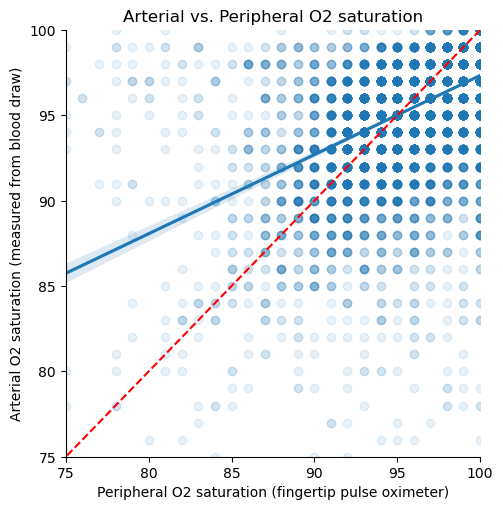

In [198]:
sns.lmplot(data = output,
                x = 'SpO2',
                y = 'SaO2',
                #hue = 'race_group',
                scatter_kws = {'alpha': 0.1}
               )

x = np.linspace(0,100,100)
y = x
plt.plot(x,y, 'r--');

plt.xlim([75,100])
plt.ylim([75,100])

plt.xlabel("Peripheral O2 saturation (fingertip pulse oximeter)")
plt.ylabel("Arterial O2 saturation (measured from blood draw)")

plt.title("Arterial vs. Peripheral O2 saturation");

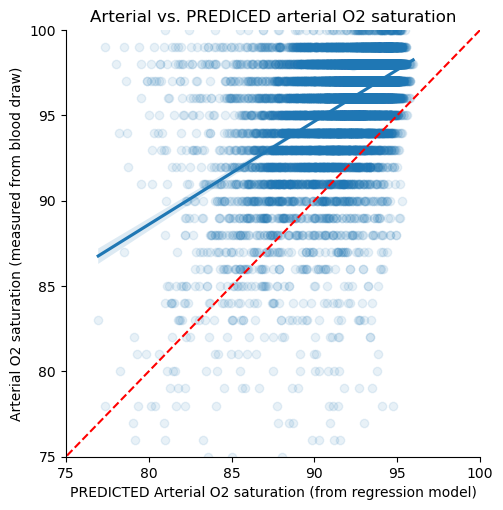

In [199]:
sns.lmplot(data = output,
                x = 'SaO2_pred',
                y = 'SaO2',
                #hue = 'race_group',
                scatter_kws = {'alpha': 0.1}
               )

x = np.linspace(0,100,100)
y = x
plt.plot(x,y, 'r--');

plt.xlim([75,100])
plt.ylim([75,100])

plt.xlabel("PREDICTED Arterial O2 saturation (from regression model)")
plt.ylabel("Arterial O2 saturation (measured from blood draw)")

plt.title("Arterial vs. PREDICED arterial O2 saturation");

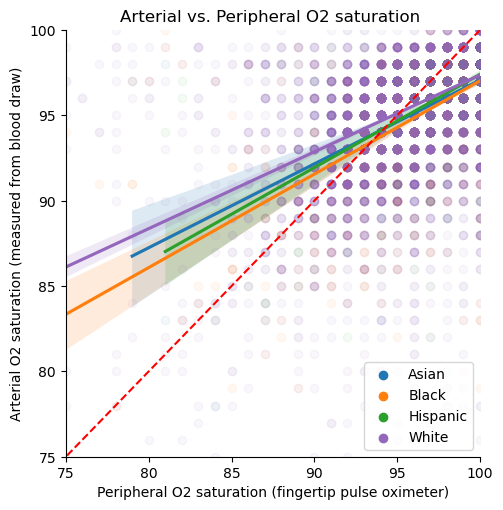

In [200]:
sns.lmplot(data = output,
                x = 'SpO2',
                y = 'SaO2',
                hue = 'race_group',
                scatter_kws = {'alpha': 0.05},
                legend=False
               )

x = np.linspace(0,100,100)
y = x
plt.plot(x,y, 'r--');

plt.xlim([75,100])
plt.ylim([75,100])

leg = plt.legend(loc = 'lower right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.xlabel("Peripheral O2 saturation (fingertip pulse oximeter)")
plt.ylabel("Arterial O2 saturation (measured from blood draw)")

plt.title("Arterial vs. Peripheral O2 saturation ");


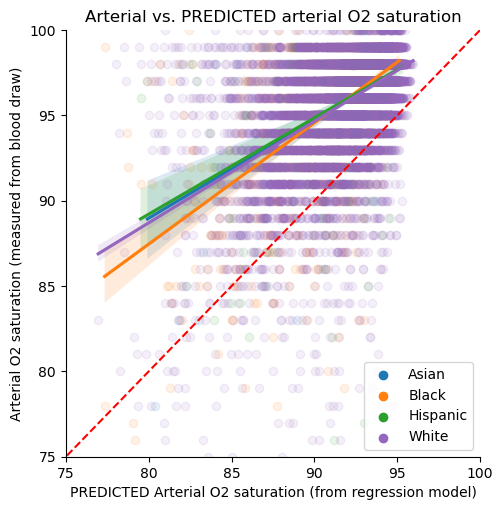

In [201]:
sns.lmplot(data = output,
                x = 'SaO2_pred',
                y = 'SaO2',
                hue = 'race_group',
                scatter_kws = {'alpha': 0.1},
                legend=False
               )

x = np.linspace(0,100,100)
y = x
plt.plot(x,y, 'r--');

plt.xlim([75,100])
plt.ylim([75,100])

leg = plt.legend(loc = 'lower right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.xlabel("PREDICTED Arterial O2 saturation (from regression model)")
plt.ylabel("Arterial O2 saturation (measured from blood draw)")

plt.title("Arterial vs. PREDICTED arterial O2 saturation");



# Alternative plots, for presentation

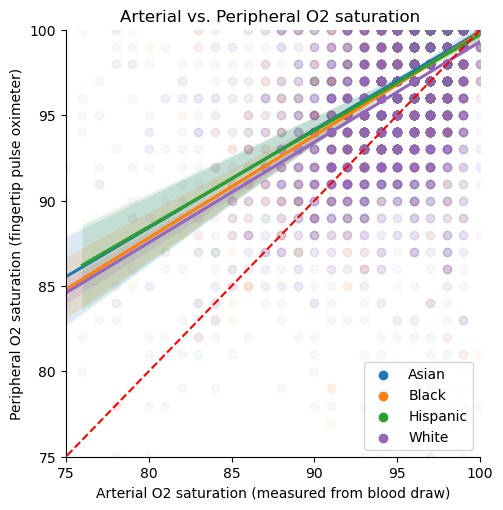

In [202]:
sns.lmplot(data = output,
                x = 'SaO2',
                y = 'SpO2',
                hue = 'race_group',
                scatter_kws = {'alpha': 0.05},
                legend=False
               )

x = np.linspace(0,100,100)
y = x
plt.plot(x,y, 'r--');

plt.xlim([75,100])
plt.ylim([75,100])

leg = plt.legend(loc = 'lower right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.ylabel("Peripheral O2 saturation (fingertip pulse oximeter)")
plt.xlabel("Arterial O2 saturation (measured from blood draw)")

plt.title("Arterial vs. Peripheral O2 saturation ");


plt.savefig('../plots/SaO2_by_SpO2_plot.png', dpi=600, format='png', bbox_inches='tight')

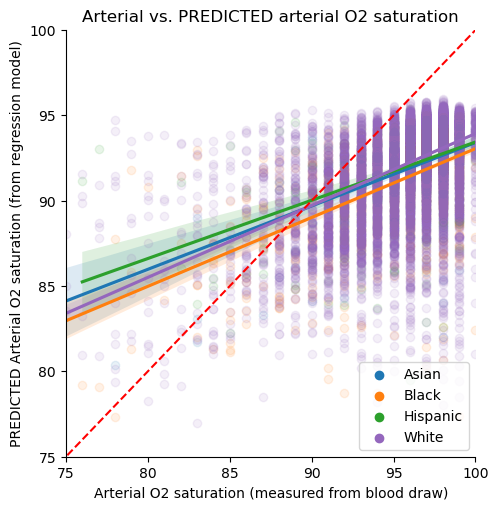

In [203]:
sns.lmplot(data = output,
                x = 'SaO2',
                y = 'SaO2_pred',
                hue = 'race_group',
                scatter_kws = {'alpha': 0.1},
                legend=False
               )

x = np.linspace(0,100,100)
y = x
plt.plot(x,y, 'r--');

plt.xlim([75,100])
plt.ylim([75,100])

leg = plt.legend(loc = 'lower right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.ylabel("PREDICTED Arterial O2 saturation (from regression model)")
plt.xlabel("Arterial O2 saturation (measured from blood draw)")

plt.title("Arterial vs. PREDICTED arterial O2 saturation");

plt.savefig('../plots/SaO2_predicted_plot.png', dpi=600, format='png', bbox_inches='tight')